# Model Evaluation

Evaluate segmentation model performance on validation set.
Compare models from architecture experiment.

In [9]:
import importlib
import sys
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
import yaml
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from src.data import NpzSegmentationDataset

## Configuration

In [14]:
# Architecture experiment models
EXPERIMENT_DIR = Path("../configs/seagrass-rgb/architecture-experiment")
CKPT_DIR = Path("../seagrass-rgb")

# Model configurations: {display_name: (config_filename, run_id)}
# UPDATE run_ids to match your W&B runs
MODELS = {
    "UNet++ 512": ("unetpp_resnet34_512.yaml", "qjfpb4m8"),
    "UNet++ 1024": ("unetpp_resnet34_1024.yaml", "mdqn7se0"),
    "SegFormer 512": ("segformer_mitb2_512.yaml", "3uav2blr"),
    "SegFormer 1024": ("segformer_mitb2_1024.yaml", "jhf1t0ih"),
}

# Inference settings
BATCH_SIZE = 16
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Models to evaluate: {list(MODELS.keys())}")

Device: cuda
Models to evaluate: ['UNet++ 512', 'UNet++ 1024', 'SegFormer 512', 'SegFormer 1024']


## Helper Functions

In [15]:
def load_model(config_path, ckpt_path, device):
    """Load model from config and checkpoint."""
    with open(config_path) as f:
        config = yaml.safe_load(f)
    
    model_config = config["model"]
    class_path = model_config["class_path"]
    init_args = model_config["init_args"]
    
    module_name, class_name = class_path.rsplit(".", 1)
    module = importlib.import_module(module_name)
    model_class = getattr(module, class_name)
    
    model = model_class(**init_args)
    checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    model.to(device)
    
    return model, config


def create_metrics(num_classes, ignore_index, device):
    """Create torchmetrics matching training setup."""
    task = "binary" if num_classes == 1 else "multiclass"
    
    return {
        "IoU": torchmetrics.JaccardIndex(
            task=task, num_classes=num_classes, ignore_index=ignore_index, average="none"
        ).to(device),
        "Precision": torchmetrics.Precision(
            task=task, num_classes=num_classes, ignore_index=ignore_index, average="none"
        ).to(device),
        "Recall": torchmetrics.Recall(
            task=task, num_classes=num_classes, ignore_index=ignore_index, average="none"
        ).to(device),
        "F1": torchmetrics.F1Score(
            task=task, num_classes=num_classes, ignore_index=ignore_index, average="none"
        ).to(device),
    }


@torch.no_grad()
def evaluate_model(model, dataloader, num_classes, ignore_index, device, target_class=1):
    """Evaluate model and return metrics for target class."""
    model.eval()
    metrics = create_metrics(num_classes, ignore_index, device)
    
    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        
        if logits.shape[1] == 1:
            preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        else:
            preds = logits.argmax(dim=1)
        
        for m in metrics.values():
            m.update(preds, labels)
    
    # Extract target class metrics
    results = {}
    for name, m in metrics.items():
        value = m.compute()
        results[name] = value[target_class].item() if len(value) > 1 else value.item()
    
    return results

## Evaluate All Models

In [ ]:
results = {}

for model_name, (config_file, ckpt_folder) in MODELS.items():
    print(f"\nEvaluating: {model_name}")
    
    config_path = EXPERIMENT_DIR / config_file
    ckpt_path = CKPT_DIR / ckpt_folder / "checkpoints/segformer_mitb2_1024_epoch-199_val-iou-0.7909.ckpt"
    
    if not ckpt_path.exists():
        print(f"  Checkpoint not found: {ckpt_path}")
        continue
    
    # Load model and config
    model, config = load_model(config_path, ckpt_path, DEVICE)
    data_config = config["data"]["init_args"]
    model_config = config["model"]["init_args"]
    
    num_classes = model_config["num_classes"]
    ignore_index = model_config.get("ignore_index", -100)
    
    # Load validation dataset
    test_transforms = A.from_dict(data_config["test_transforms"])
    val_dataset = NpzSegmentationDataset(data_config["val_chip_dir"], transforms=test_transforms)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
    
    print(f"  Validation tiles: {len(val_dataset)}")
    
    images, labels = next(iter(val_loader))
    with torch.no_grad():
      logits = model(images.to(DEVICE))
      preds = logits.argmax(dim=1)
    print(f"Unique preds: {preds.unique()}")
    print(f"Unique labels: {labels.unique()}")
    print(f"Pred seagrass %: {(preds == 1).float().mean():.3f}")
    print(f"Label seagrass %: {(labels == 1).float().mean():.3f}")
    
    print(test_transforms)
    # Evaluate
    results[model_name] = evaluate_model(model, val_loader, num_classes, ignore_index, DEVICE)
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    
    print(f"  IoU: {results[model_name]['IoU']:.4f}")

print(f"\nEvaluated {len(results)} models")


Evaluating: UNet++ 512
  Checkpoint not found: ../seagrass-rgb/qjfpb4m8/checkpoints/segformer_mitb2_1024_epoch-199_val-iou-0.7909.ckpt

Evaluating: UNet++ 1024
  Checkpoint not found: ../seagrass-rgb/mdqn7se0/checkpoints/segformer_mitb2_1024_epoch-199_val-iou-0.7909.ckpt

Evaluating: SegFormer 512
  Checkpoint not found: ../seagrass-rgb/3uav2blr/checkpoints/segformer_mitb2_1024_epoch-199_val-iou-0.7909.ckpt

Evaluating: SegFormer 1024
  Validation tiles: 458
Unique preds: tensor([0, 1], device='cuda:0')
Unique labels: tensor([0, 1])
Pred seagrass %: 0.176
Label seagrass %: 0.165


Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

## Results Table

Models in columns, metrics in rows.

In [22]:
# Create table: metrics as rows, models as columns
df_results = pd.DataFrame(results).T
df_table = df_results.T.round(4)

print("Validation Set Metrics (Seagrass Class)")
print("=" * 60)
display(df_table)

Validation Set Metrics (Seagrass Class)


,SegFormer 1024
IoU,0.6252
Precision,0.8597
Recall,0.6963
F1,0.7694


In [18]:
# Export table for paper
df_table.to_csv("../outputs/architecture_experiment_metrics.csv")
print("Saved to outputs/architecture_experiment_metrics.csv")

Saved to outputs/architecture_experiment_metrics.csv


## Bar Plot

Models on x-axis, faceted by metric. Academic ggplot style.

In [19]:
# Set ggplot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 150,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Color palette
COLORS = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

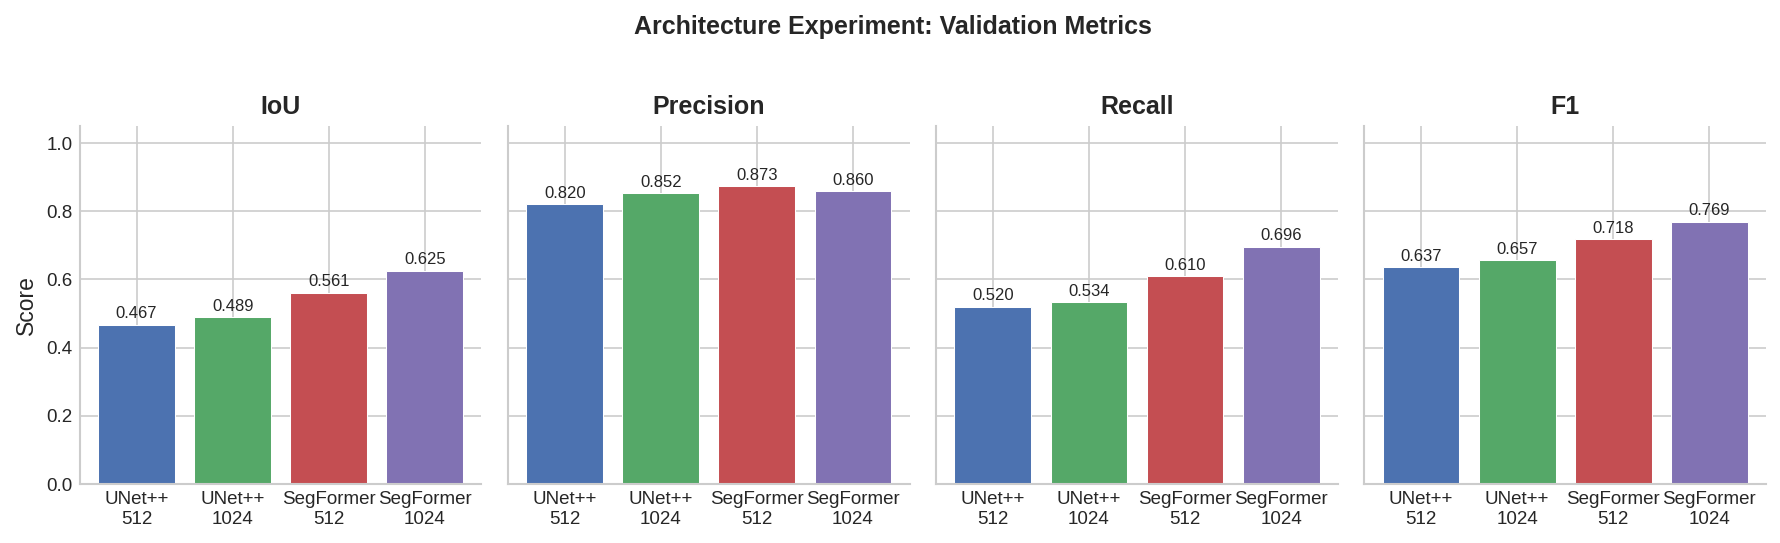

Saved to outputs/architecture_experiment_barplot.png


In [20]:
# Reshape data for plotting
df_long = df_results.reset_index().melt(
    id_vars="index", 
    var_name="Metric", 
    value_name="Value"
)
df_long = df_long.rename(columns={"index": "Model"})

# Create faceted bar plot
metrics = ["IoU", "Precision", "Recall", "F1"]
models = list(results.keys())

fig, axes = plt.subplots(1, 4, figsize=(12, 3.5), sharey=True)

for ax, metric in zip(axes, metrics):
    values = [results[m][metric] for m in models]
    bars = ax.bar(range(len(models)), values, color=COLORS, edgecolor="white", linewidth=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.01, 
            f"{val:.3f}", 
            ha="center", 
            va="bottom", 
            fontsize=8
        )
    
    ax.set_title(metric, fontweight="bold")
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels([m.replace(" ", "\n") for m in models], rotation=0)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel("")

axes[0].set_ylabel("Score")

fig.suptitle("Architecture Experiment: Validation Metrics", fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../outputs/architecture_experiment_barplot.png", bbox_inches="tight", dpi=300)
plt.savefig("../outputs/architecture_experiment_barplot.pdf", bbox_inches="tight")
plt.show()

print("Saved to outputs/architecture_experiment_barplot.png")

## Summary

In [ ]:
# Find best model for each metric
print("Best model by metric:")
print("-" * 40)
for metric in metrics:
    best_model = max(results, key=lambda m: results[m][metric])
    best_value = results[best_model][metric]
    print(f"{metric:12s}: {best_model} ({best_value:.4f})")